# Demo program for calculating efficiency and transmission functions for thermal baths

The purpose of this notebook is to try and calculate the efficiency and power outputs for a two terminal system coupled to thermal baths. The asssumption is that the right bath (R) is colder than the left bath (L), and has a higher electrochemical potential. We are limiting to heat engines, thus we should get a heat and electric current flow from L to R which generates power. Since the process is governed by the temperature and potential bias, the corresponding quantities for L and R are expressed in terms of the biases and the reference, where the temperature and potential at R are references.

$$
\Delta T = T_L - T_R \geq 0 \implies T_R = T, \: T_L = T +  \Delta T \\
\Delta \mu = \mu_L - \mu_R \leq 0 \implies \mu_R = \mu, \: \mu_L = \mu + \Delta \mu
$$

In addition, the reference potential is set to zero, while the temperature is measured after absolute zero. By default, $h = e = 1$, while $k_B$ has units meV/K. Note that we also assume $V = \mu$ with positive $e$, letting the voltage and potential bias have the same sign. One can just multiply the electric current and the bias by minus one if necessary, but here we are considering particle flow, not charge flow. As such, a negative current means that electrons are **leaving** the corresponding bath, which means that the charge current is positive. 

## Transmission function

The core task of this demo is to adapt the transmission function to maximize power or efficiency with regards to a given efficiency or power respectively. For exchange between two thermal baths, it is well known that the ideal transmission function is a band pass, which simply lets through electrons between two energies, $E_0$ and $E_1$, while blocking all others. The balance between power output and efficiency is encoded in the width of the band pass. For a function that tends to the delta function around the exchange energy, 

$$
E^* = \frac{T_L \mu_R - T_R \mu_L}{T_L - T_R},
$$

the efficiency tends to Carnot efficieny. Conversely, a band pass where $E_0 = E^*$ and $E_1$ tends to infinity maximizes power output at the cost of efficieny (but the efficiency does not necessarily tend to zero!). This is highly reasonable, since this allows for all energies at which more electrons leave L than arrive from R according to their Fermi distributions.

While it is possible to simply maximize the power output, maximizing the efficieny without consideration of the power gives a poorly defined problem, since the power output tends to zero when the efficiency tends to Carnot efficieny, equivalently to a reversible process (at least this seems true for this thermal setup). While the program tends to give the correct function, a delta function centered at the exchange energy, the actual value of the efficiency fluctuates highly, as the power output fluctuates around zero, between positive and negative.

## Thermodynamic laws check

It is important to check that the first and second thermodynamic laws are fulfilled to assure numerical stability.


In [30]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import mpmath as mp

from scipy.optimize import minimize, fsolve

In [31]:
import thermo_funcs
thermo_funcs.h = 4
print(thermo_funcs.h)

4


In [32]:
# Global constants
h = 1#6.6260688e-34 #J/s
e = 1#1.60227646e-19 #C
kb = 1#8.617342e-2#meV/K 1.380650e-23 #J/K
optim= False
targeting_p = True

In [33]:
#Define global ranges and constants
mu = 0
T = 1
r_deltamu = np.linspace(-2, 0,10)
r_deltaT = np.linspace(0,2, 10)
E0_set = 10; E1_set = 1000


r_TL = T+r_deltaT/2
r_TR = T-r_deltaT/2
#r_TL = np.ones_like(r_TR)*T

muR = mu
r_muL = mu + r_deltamu

#r_E = np.linspace(E0,E1,100)
print(kb*T)
#print(np.sum(r_E - r_deltamu, axis = 1))


1


In [34]:
#Define functions
def fermi_dist(E, mu, T):
    f_dist = 1/(1+np.exp((E-mu)/(T*kb)))
    return f_dist

def fermi_integrated(E0,E1, mu, T, type="electric"):
    den = kb*T
    if type == "electric":
        integ = -E0 + E1 + kb*T*np.log((np.exp(E0/den)+np.exp(mu/den))/(np.exp(E1/den)+np.exp(mu/den)))
    elif type == "heat":
        integ = mu*(E0+E1+kb*T*np.log((np.exp(E0/den)+np.exp(mu/den))/(np.exp(E1/den)+np.exp(mu/den)))) + \
                kb*T*(E0*np.log(1+np.exp((mu-E0)/den)) - E1*np.log(1+np.exp((mu-E1)/den)) 
                      - kb*T*mp.polylog(2,-np.exp((mu-E0)/den)) + kb*T*mp.polylog(2,-np.exp((mu-E1)/den)))
    elif type == "energy":
        integ = kb*T*(E0*np.log(1+np.exp((mu-E0)/den)) - E1*np.log(1+np.exp((mu-E1)/den)) 
                      - kb*T*mp.polylog(2,-np.exp((mu-E0)/den)) + kb*T*mp.polylog(2,-np.exp((mu-E1)/den)))
    else:
        print("Invalid current type")
        return -1
    return integ

def current_integral(E0, E1, muL, TL, muR, TR, transf, occupf = fermi_dist, type = "electric"):
    if type == "electric":
        coeff = lambda E: e
    elif type == "heat":
        coeff = lambda E: (E-muL)
    elif type == "heatR":
        coeff = lambda E: (E-muR)
    elif type == "energy":
        coeff = lambda E: E
    else:
        print("Invalid current type")
        return -1
    if type == "heatR":
        integrand = lambda E: 1/h*coeff(E)*transf(E)*(-occupf(E,muL,TL)+ occupf(E,muR,TR))
    else:    
        integrand = lambda E: 1/h*coeff(E)*transf(E)*(occupf(E,muL,TL)- occupf(E,muR,TR))
    #print(integrand(2))
    # If we have a delta function?
    #if E1 - E0 < 1:
    #    return integrand((E0+E1)/2)*(E0+E1)/2

    current, err = integrate.quad(integrand, E0, E1, args=())
    return current

def simple_current(E0,E1, muL, TL, muR, TR, type = "electric", N=1, method = "integrate"):
    if method == "integrate":
        def transf(E):
            #return N*(np.heaviside(E-E0,1)*np.heaviside(E1-E,1))
            return N
        return current_integral(E0,E1, muL, TL, muR, TR, transf, type = type)
    if type == "heatR":
        current = 1/h*N*(-fermi_integrated(E0,E1,muL,TL, type = "heat") + fermi_integrated(E0,E1,muR,TR, type = "heat"))
    else:
        current = 1/h*N*(fermi_integrated(E0,E1,muL,TL, type) - fermi_integrated(E0,E1,mu,T, type))
    return current

def w_simple_current(E, muL, TL, muR, TR, type = "electric", N=1):
    return simple_current(E[0],E[1], muL, TL, muR, TR, type = type, N=1)

def f_maximize_power(E, muL, TL, muR, TR, target_power = 0):
    electric = w_simple_current(E, muL, TL, muR, TR, type = "electric")
    power = -e*(muL-muR)*electric
    #if target_eff > 0:
    #    heat = w_simple_current(E, deltamu, deltaT, type = "heat")
    #    eff = power/heat
    return -power

def f_maximize_eff(E, muL, TL, muR, TR, target_eff = 0):
    electric = w_simple_current(E, muL, TL, muR, TR,type = "electric")
    heat = w_simple_current(E, muL, TL, muR, TR, type = "heat")
    power = -e*(muL - muR)*electric
    #if heat == 0:
    #    return np.inf
    eff = power/heat
    #if np.abs(eff) > 1:
    #    return np.inf
    return -eff

# To make sure that we are in the heat engine regime (optimizing gets weird otherwise.)
# However this constraint seems to lead to a badly behaved problem. It could be better/easier to filter the output data afterwards to remove the results where power < 0
def carnot(TL,TR):
    return (1-TR/TL)

def pmax(TL, TR, N=1):
    A = 0.0321
    p = A * np.pi**2/h * N * kb**2 *(TL-TR)**2
    return p

def eff_limit(E, muL, TL, muR, TR):
    electric = w_simple_current(E, muL, TL, muR, TR, type = "electric")
    heat = w_simple_current(E, muL, TL, muR, TR, type = "heat")
    power = -e*(muL - muR)*electric
    
    #if power < 0:
    #    return -1
    #if np.abs(power) < 1e-10:
    #    return -1

    eff = power/np.abs(heat) if heat != 0 else -1
    return carnot(TL,TR) - eff if eff > 0 else eff

def eff_constraint(E, muL, TL, muR, TR, target_eff):
    electric = w_simple_current(E,muL, TL, muR, TR, type = "electric")
    heat = w_simple_current(E, muL, TL, muR, TR, type = "heat")
    power = -e*(muL-muR)*electric
    eff = power/heat if heat != 0 else -1
    return target_eff - eff

def pow_constraint(E, muL, TL, muR, TR, target_pow):
    electric = w_simple_current(E,muL, TL, muR, TR, type = "electric")
    power = -e*(muL-muR)*electric
    return target_pow-power

def E_max(muL, TL, muR, TR):
    if TL-TR == 0:
        return 0
    #print(((deltaT+T)*mu - T*(deltamu+mu))/deltaT)
    return (TL*muR - TR*muL)/(TL-TR)

def correct_E1(muL, TL, muR, TR, target_p):
    if muR != 0:
        print("Only for muR = 0 for now :(")
        return -1
    def GL(E):
        return kb*TL/h * np.log(1+np.exp(-(E-muL)/(kb*TL)))
    def GR(E):
        return kb*TR/h * np.log(1+np.exp(-(E)/(kb*TR)))
    def GL_prim(E):
        return e/h * fermi_dist(E, muL,TL)
    def FL_prim(E):
        #print(mp.polylog(1, -np.exp(-(E-muL)/(kb*TL))))
        polylog = np.frompyfunc(mp.polylog, 2, 1)
        right = -e/(kb*TL)*np.exp(-(E-muL)/(kb*TL))*polylog(1, -np.exp(-(E-muL)/(kb*TL)))
        left = E*GL_prim(E)
        return left - right
    E0 = E_max(muL, TL, muR, TR)
    GL_0 = GL(E0)
    GL_prim_0 = GL_prim(E0)
    GR_0 = GR(E0)
    FL_prim_0 = FL_prim(E0)
    #print(FL_prim_0)
    def e_solver(E1):
        pgen = muL*(-GL_0+GR_0+GL(E1)-GR(E1))
        #print(pgen)
        return pgen - target_p
        #J_prim = FL_prim_0 - FL_prim(E1)
        #P_prim = e*(GL_0+GR_0-GL(E1)-GR(E1)) + muL*(GL_prim_0-GL_prim(E1))
        #if P_prim == 0:
        #    return E0
        #print(GL_0+GR_0-GL(E1)-GR(E1))
        #print((J_prim/P_prim))
        #return float((-(1-J_prim/P_prim)*muL - E1)[0])

    res = fsolve(e_solver, E0*5)
    return res[0] 

def correct_Jprim_Pprim(E0,E1,muL, TL, muR, TR):
    polylog = np.frompyfunc(mp.polylog, 2, 1)
    if muR != 0:
        print("Only for muR = 0 for now :(")
        return -1
    def GL(E):
        return kb*TL/h * np.log(1+np.exp(-(E-muL)/(kb*TL)))
    def GR(E):
        return kb*TR/h * np.log(1+np.exp(-(E)/(kb*TR)))
    def FL(E):
        t_one = E*GL(E)
        t_two = - (kb*TL)**2/h * polylog(2, -np.exp(-(E-muL)/(kb*TL)))
        t_three = muL*(E - kb*TL*np.log(np.exp(E/(kb*TL)) + np.exp(muL/(kb*TL))))
        return t_one + t_two + t_three
    def FR(E):
        t_one = (E-muL)*GR(E)
        t_two = - (kb*TR)**2/h * polylog(2, -np.exp(-(E)/(kb*TR)))
        #t_three = muL*(E - kb*TL**np.log(np.exp(E/(kb*T) - np.exp(muL/(kb*T)))))

        return t_one + t_two
    
    def GL_prim(E):
        return 1/h * np.exp((-E+muL)/(kb*TL))/(1+np.exp((-E+muL)/(kb*TL)))
        #return 1/h * fermi_dist(E, muL,TL)
    def FL_prim(E):
        #print(mp.polylog(1, -np.exp(-(E-muL)/(kb*TL))))
        
        
        t_one = E*GL_prim(E)
        t_two = kb*TL/h * np.log(1+np.exp((-E+muL)/(kb*TL)))
        t_three = - kb*TL *np.log(np.exp(E/(kb*TL)) + np.exp(muL/(kb*TL)))
        t_four = E - muL*np.exp(muL/(kb*TL))/(np.exp(E/(kb*TL))+np.exp(muL/(kb*TL)))
        #right = (kb*TL)**2/h * (e/(kb*TL)*polylog(1, -np.exp(-(E-muL)/(kb*TL))))
        #left = E*GL_prim(E)
        return t_one + t_two + t_three + t_four
    def FR_prim(E):
        return - GR(E)
   # E0 = E_max(muL, TL, muR, TR)
    GL_0 = GL(E0)
    GL_prim_0 = GL_prim(E0)
    GR_0 = GR(E0)
    FL_prim_0 = FL_prim(E0)
    #print(FL_prim_0)
    #def e_solver(E1):
    #    pgen = muL*(-GL_0+GR_0+GL(E1)-GR(E1))
    #    return pgen - target_p
    #print(f"P = {muL * (GL_0-GR_0-GL(E1)+GR(E1))}")
    Jprim = FL_prim_0 - FL_prim(E1) - FR_prim(E0) + FR_prim(E1)
    Pprim = -(GL_0-GR_0-GL(E1)+GR(E1) + muL*(GL_prim_0-GL_prim(E1)))

    JL = FL(E0) - FL(E1) - FR(E0) + FR(E1)
    P = muL*(-GL(E0) + GL(E1) + GR(E0) - GR(E1))
        #if P_prim == 0:

        #    return E0
        #print(GL_0+GR_0-GL(E1)-GR(E1))
        #print((J_prim/P_prim))
        #return float((-(1-J_prim/P_prim)*muL - E1)[0])

    #res = fsolve(e_solver, E0*5)
    return (float(Jprim), float(Pprim), float(JL), float(P)) 


In [35]:
#Calculate the currents and check that the 1st law is fulfilled (two terminals: left current = - right current)
if optim:
    if targeting_p:
        targetf = pmax
        maxf = f_maximize_eff
        constrf = pow_constraint
    else:
        targetf = carnot
        maxf = f_maximize_power
        constrf = eff_constraint
    r_electric = []
    r_energy = []
    r_heat = []
    r_heatR = []
    r_E0 = []
    r_E1 = []
    for TL, TR in np.array([r_TL, r_TR]).T:
        target_eff = 0.5*targetf(TL,TR)
        tmp_electric = []
        tmp_heat = []
        tmp_energy = []
        tmp_heatR = []
        tmp_E0 = []
        tmp_E1 = []
        for muL in r_muL:
            #TODO Much more effective maximizing function
            res = minimize(maxf, [0.5*E_max(muL, TL, muR, TR),1.5*E_max(muL, TL, muR, TR)], args = (muL, TL, muR, TR), 
                        constraints= [{'type':'ineq', 'fun': lambda E: E[1] - E[0]},
                                      {'type': 'eq', 'fun':constrf, 'args':(muL, TL, muR, TR,target_eff)}]).x
                                        #{'type':'ineq', 'fun': eff_limit, 'args': (deltamu, deltaT)}]).x#, bounds = ((E0, E0), (E1,20000))).x
            #print(E_max(deltamu, deltaT, mu, T))
            #print(res)
            tmp_electric.append(w_simple_current(res, muL, TL, muR, TR, type = "electric"))
            tmp_energy.append(w_simple_current(res, muL, TL, muR, TR, type = "energy"))
            tmp_heat.append(w_simple_current(res, muL, TL, muR, TR, type = "heat"))
            tmp_heatR.append(w_simple_current(res, muL, TL, muR, TR, type = "heatR"))
            tmp_E0.append(res[0])
            tmp_E1.append(res[1])

        r_electric.append(tmp_electric)
        r_energy.append(tmp_energy)
        r_heat.append(tmp_heat)
        r_heatR.append(tmp_heatR)
        r_E0.append(tmp_E0)
        r_E1.append(tmp_E1)
    r_electric = np.array(r_electric)
    r_energy = np.array(r_energy)
    r_heat = np.array(r_heat)
    r_heatR = np.array(r_heatR)
    r_E0 = np.array(r_E0)
    r_E1 = np.array(r_E1)
else:
    method = "integrate"
    coeff_p = 0.4
    r_E0 = np.array([[E_max(muL, TL, muR, TR) for muL in r_muL] for TL, TR in np.array([r_TL, r_TR]).T])
    #r_E1 = np.array([[1 for muL in r_muL] for TL, TR in np.array([r_TL, r_TR]).T])
    r_E1 = np.array([[correct_E1(muL, TL, muR, TR, coeff_p*pmax(TL,TR)) for muL in r_muL] for TL, TR in np.array([r_TL, r_TR]).T])
    
    r_energy = np.array([[simple_current(r_E0[i,j], r_E1[i,j], muL, TL, muR, TR , type = "energy", method = method) for j,muL in enumerate(r_muL)] for i, (TL, TR) in enumerate(np.array([r_TL, r_TR]).T)])
    r_electric = np.array([[simple_current(r_E0[i,j], r_E1[i,j], muL, TL, muR, TR , type = "electric", method = method) for j,muL in enumerate(r_muL)] for i, (TL, TR) in enumerate(np.array([r_TL, r_TR]).T)])
    r_heat = np.array([[simple_current(r_E0[i,j], r_E1[i,j], muL, TL, muR, TR , type = "heat", method = method) for j,muL in enumerate(r_muL)] for i, (TL, TR) in enumerate(np.array([r_TL, r_TR]).T)])
    r_heatR = np.array([[simple_current(r_E0[i,j], r_E1[i,j], muL, TL, muR, TR , type = "heatR", method = method) for j,muL in enumerate(r_muL)] for i, (TL, TR) in enumerate(np.array([r_TL, r_TR]).T)])
    
    #r_electric = np.array([[simple_current(E_max(muL, TL, muR, TR), correct_E1(muL, TL, muR, TR), muL, TL, muR, TR , type = "electric", method = method) for muL in r_muL] for TL, TR in np.array([r_TL, r_TR]).T])
    #r_heat = np.array([[simple_current(E_max(muL, TL, muR, TR), correct_E1(muL, TL, muR, TR), muL, TL, muR, TR , type = "heat", method = method) for muL in r_muL] for TL, TR in np.array([r_TL, r_TR]).T])
    #r_heatR = np.array([[simple_current(E_max(muL, TL, muR, TR), correct_E1(muL, TL, muR, TR), muL, TL, muR, TR, type = "heatR", method = method) for muL in r_muL] for TL, TR in np.array([r_TL, r_TR]).T])
    #for TL, TR in np.array([r_TL, r_TR]).T:
    #    print(TL-TR)
    # r_energy = np.array([[simple_current(E0_set,E1_set, deltamu, deltaT, type = "energy") for deltamu in r_deltamu] for deltaT in r_deltaT])
    # r_electric = np.array([[simple_current(E0_set,E1_set, deltamu, deltaT, type = "electric") for deltamu in r_deltamu] for deltaT in r_deltaT])
    # r_heat = np.array([[simple_current(E0_set,E1_set, deltamu, deltaT, type = "heat") for deltamu in r_deltamu] for deltaT in r_deltaT])
    # r_heatR = np.array([[simple_current(E0_set,E1_set, deltamu, deltaT, type = "heatR") for deltamu in r_deltamu] for deltaT in r_deltaT])

#print(r_heat + r_heatR)

# print(r_deltamu.shape)
# print(r_electric.shape)
# print(r_heat.shape)
# print(r_heatR.shape)
check = np.any(np.abs(-e*(r_muL-muR)*r_electric - (r_heat + r_heatR)) > 1e-10)
entropy_check = np.any((-r_heat/r_TL.reshape(-1,1) - r_heatR/r_TR.reshape(-1,1)) < 0)
#print(np.abs(-r_deltamu*r_electric - (r_heat + r_heatR)))
#print(r_energy - ((r_deltamu+mu)*r_electric + r_heat))
#print(np.any((-r_heat/(T+r_deltaT.reshape(-1,1)) - r_heatR/T) < 0))
print(f"Is the energy conserved? {not check}")
if check:
    print(f"The number of violating elements: {len(np.where(np.abs(-e*(r_muL-muR)*r_electric - (r_heat + r_heatR))> 1e-10)[0])}")

print(f"Is entropy increasing? {not entropy_check}")
if entropy_check:
    print(f"The number of violating elements:{len(np.where((-r_heat/r_TL.reshape(-1,1) - r_heatR/r_TR.reshape(-1,1)) < 0))}")

#print(r_E1)
power = r_heat+r_heatR
#print(power)

Is the energy conserved? True
Is entropy increasing? False
The number of violating elements:2


C:\Users\elsad\AppData\Local\Temp\ipykernel_15008\137358323.py:155: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  res = fsolve(e_solver, E0*5)
C:\Users\elsad\AppData\Local\Temp\ipykernel_15008\137358323.py:128: RuntimeWarning: invalid value encountered in scalar divide
  return kb*TR/h * np.log(1+np.exp(-(E)/(kb*TR)))
C:\Users\elsad\AppData\Local\Temp\ipykernel_15008\137358323.py:128: RuntimeWarning: invalid value encountered in divide
  return kb*TR/h * np.log(1+np.exp(-(E)/(kb*TR)))
C:\Users\elsad\AppData\Local\Temp\ipykernel_15008\137358323.py:128: RuntimeWarning: divide by zero encountered in divide
  return kb*TR/h * np.log(1+np.exp(-(E)/(kb*TR)))
C:\Users\elsad\AppData\Local\Temp\ipykernel_15008\137358323.py:3: RuntimeWarning: overflow encountered in exp
  f_dist = 1/(1+np.exp((E-mu)/(T*kb)))
C:\Users\elsad\AppData\Local\Temp\ipykernel_15008\137358323.py:3: RuntimeWarning: invalid value encountered in 

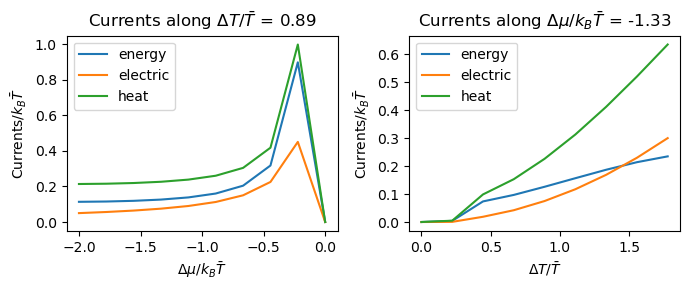

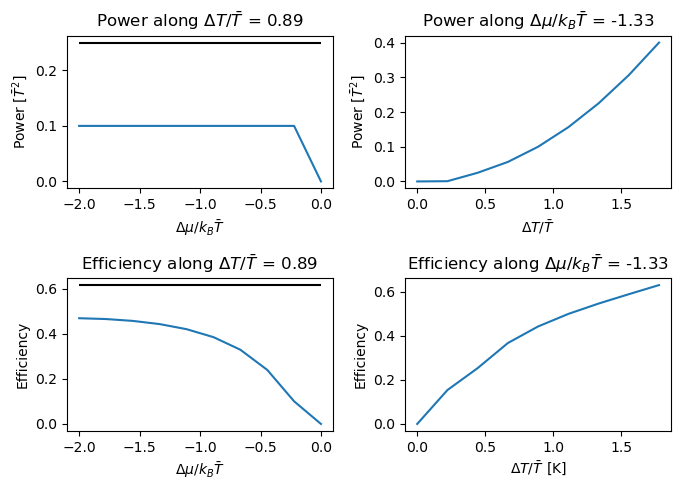

In [36]:
# Plotting power and efficiency
#power = -e*(r_muL-muR)*r_electric
power = r_heat+r_heatR
#eff = power/r_heat
eff = np.divide(power, r_heat, where = r_heat !=0)
bad_eff = np.where(np.abs(eff) > 1)
#eff[bad_eff] = np.nan
#print(f"The efficiency is {eff}")

#print(r_electric[10,0])
#print(r_heat[10,0])
#print(r_energy[10,0])

T_idx = 4
mu_idx = 3
#print(f"The generated power is {power[T_idx,:]}")
#print(r_heat[T_idx,:])

#print(r_E0)
#carnot = 

fig, axs = plt.subplots(1,2, figsize=(7,3))
axs[0].set_title(rf"Currents along $\Delta T / \bar T$ = {r_deltaT[T_idx]:.2f}")
axs[0].plot(r_deltamu, r_energy[T_idx,:], label = "energy")
axs[0].plot(r_deltamu, r_electric[T_idx,:], label = "electric")
axs[0].plot(r_deltamu, r_heat[T_idx,:], label = "heat")
axs[0].set_xlabel(rf"$\Delta \mu / k_B \bar T$")
axs[0].set_ylabel(rf"Currents/$k_B \bar T$")
axs[0].legend()
axs[1].set_title(rf"Currents along $\Delta \mu / k_B \bar T$ = {r_deltamu[mu_idx]:.2f}")
axs[1].plot(r_deltaT, r_energy[:,mu_idx], label = "energy")
axs[1].plot(r_deltaT, r_electric[:, mu_idx], label = "electric")
axs[1].plot(r_deltaT, r_heat[:,mu_idx], label = "heat")
axs[1].set_xlabel(rf"$\Delta T / \bar T$")
axs[1].set_ylabel(rf"Currents/$k_B \bar T$")
axs[1].legend()
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2,2, figsize=(7,5))
axs[0,0].set_title(rf"Power along $\Delta T / \bar T$ = {r_deltaT[T_idx]:.2f}")
axs[0,0].plot(r_deltamu, (power[T_idx,:]))
axs[0,0].hlines(pmax(r_TL[T_idx], r_TR[T_idx]), r_deltamu[0], r_deltamu[-1], colors = 'black')
axs[0,0].set_xlabel(rf"$\Delta \mu / k_B \bar T$")
axs[0,0].set_ylabel(rf"Power [$\bar T^2$]")
axs[0,1].set_title(rf"Power along $\Delta \mu/k_B \bar T$ = {r_deltamu[mu_idx]:.2f}")
axs[0,1].plot(r_deltaT, power[:,mu_idx])
axs[0,1].set_xlabel(rf"$\Delta T / \bar T$")
axs[0,1].set_ylabel(rf"Power [$\bar T^2$]")
axs[1,0].set_title(rf"Efficiency along $\Delta T / \bar T$ = {r_deltaT[T_idx]:.2f}")
axs[1,0].plot(r_deltamu, eff[T_idx,:])
axs[1,0].hlines(carnot(r_TL[T_idx], r_TR[T_idx]), r_deltamu[0], r_deltamu[-1], colors = 'black')
axs[1,0].set_xlabel(rf"$\Delta \mu/k_B \bar T$")
axs[1,0].set_ylabel(rf"Efficiency")
axs[1,1].set_title(rf"Efficiency along $\Delta \mu/k_B \bar T$ = {r_deltamu[mu_idx]:.2f}")
axs[1,1].plot(r_deltaT, eff[:,mu_idx])
axs[1,1].set_xlabel(rf"$\Delta T / \bar T$ [K]")
axs[1,1].set_ylabel(rf"Efficiency")
plt.tight_layout()
plt.show()


## Arbitrary transmission function

While the band pass structure for transmission functions is well known to be optimal for currents between thermal baths, for potential non-thermal baths, this is no longer guaranteed. In preparation of analyzing non-thermal baths, we try to numerically find the ideal transmission function and compare with the band pass. Hopefully, the optimization should yield a suitable band pass as transmission function, with some room for error

In [37]:
# Learning a distribution without (with weaker) prior assumptions...
# Gaussian processes, Bayesian loop? What is our data and what is our input? Preferably without using formulas for max possible efficiency and power (except Carnot limit)
# Let's start by rewriting what we did above, but dividing T_LR into chunks
def log_coeff(E, muL, TL, occupf_L = fermi_dist):
    coeff = -kb*TL*np.log(occupf_L(E, muL, TL)/(1-occupf_L(E, muL, TL)))
    return coeff

def calc_dP_dtau(E, muL, TL, muR, TR, occupf_L = fermi_dist, occupf_R= fermi_dist):
    coeff = -log_coeff(E, muL, TL, occupf_L)
    dP_dtau = -1/h * E * (coeff) * (occupf_L(E, muL, TL) - occupf_R(E,muR,TR))
    return dP_dtau


def chunk_current_integral(transf,E_mids,muL, TL ,muR, TR, deltaE, occupf_L = fermi_dist, occupf_R=fermi_dist,type = "electric", return_integrands = False):
    if type == "electric":
        coeff = lambda E: e
    elif type == "heat":
        if occupf_L != fermi_dist:
            coeff = lambda E: log_coeff(E,muL,TL,occupf_L)
        else:
            coeff = lambda E: (E-muL)
    elif type == "heatR":
        coeff = lambda E: -(E-muR)
    elif type == "energy":
        coeff = lambda E: E
    else:
        print("Invalid current type")
        return -1

    #if type == "heatR":
    #    occupdiff = -occupf_L(E_mids,muL,TL)+ occupf_R(E_mids,muR,TR)
    #else:    
    occupdiff = occupf_L(E_mids,muL,TL)- occupf_R(E_mids,muR,TR)
    #print(coeff(E_mids))
    #print(transf)
    #print(occupdiff)
    integrands = 1/h*coeff(E_mids)*transf*occupdiff*deltaE
    #if np.any(integrands < 0):
    #    current = -100
    #else:
    current = np.sum(integrands)   
    if return_integrands:
        return current, integrands
    return current
    
def chunk_maximize_eff(transf, E_mids, muL, TL ,muR, TR, deltaE,occupf_L = fermi_dist, occupf_R=fermi_dist):
    #electric, integrands = chunk_current_integral(transf, E_mids, muL, TL ,muR, TR, deltaE, occupf_L, occupf_R,type = "electric", return_integrands=True)

    heat = chunk_current_integral(transf, E_mids, muL, TL ,muR, TR, deltaE, occupf_L,occupf_R,type = "heat")
    heatR = chunk_current_integral(transf, E_mids, muL, TL ,muR, TR, deltaE,occupf_L,occupf_R,type = "heatR")
    power = heat + heatR#-e*(muL-muR)*electric
    #if heat == 0:
    #    return np.inf
    eff = power/heat
    #if np.abs(eff) > 1:
    #    return np.inf
    return -eff


def chunk_maximize_power(transf, E_mids, muL, TL ,muR, TR, deltaE,occupf_L = fermi_dist):
    electric = chunk_current_integral(transf, E_mids, muL, TL ,muR, TR, deltaE, occupf_L,type = "electric")
    power = -e*(muL-muR)*electric
    #if target_eff > 0:
    #    heat = w_simple_current(E, deltamu, deltaT, type = "heat")
    #    eff = power/heat
    return -power

def chunk_eff_constraint(transf, E_mids, muL, TL ,muR, TR, deltaE, target_eff,occupf_L = fermi_dist):
#    electric = chunk_current_integral(transf,E_mids, muL, TL ,muR, TR, deltaE, type = "electric")
    heat = chunk_current_integral(transf, E_mids, muL, TL ,muR, TR, deltaE, occupf_L,type = "heat")
    heatR = chunk_current_integral(transf, E_mids, muL, TL ,muR, TR, deltaE,occupf_L,type = "heatR")
    power = heat + heatR#-e*(muL-muR)*electricpower = -e*(muL-muR)*electric
    eff = power/heat if heat != 0 else -1
    return target_eff - eff

def chunk_pow_constraint(transf, E_mids, muL, TL, muR, TR, deltaE, target_pow, occupf_L = fermi_dist):
#    electric = chunk_current_integral(transf,E_mids, muL, TL ,muR, TR, deltaE, type = "electric")
#    power = -e*(muL-muR)*electric
    heat = chunk_current_integral(transf, E_mids, muL, TL ,muR, TR, deltaE, occupf_L,type = "heat")
    heatR = chunk_current_integral(transf, E_mids, muL, TL ,muR, TR, deltaE,occupf_L,type = "heatR")
    power = heat + heatR#-e*(muL-muR)*electricpower = -e*(muL-muR)*electric
    return target_pow-power

def chunk_constraint(transf, E_mids, muL, TL, muR, TR, deltaE):
    electric, integrands = chunk_current_integral(transf, E_mids, muL, TL ,muR, TR, deltaE,type = "heat", return_integrands=True)
    sgn_integrands = np.sign(integrands[np.argwhere(integrands != 0)]).flatten()-1#np.sign(np.where(integrands != 0)[0])-1
    #print(sgn_integrands)
    print(np.sum(sgn_integrands))
    return np.sum(sgn_integrands)

def pertub_fermi(E, muL, TL, fpertub = None):
    fermi = fermi_dist(E,muL,TL)
    pertub = fpertub(E)
    dist = fermi + pertub
    dist[dist < 0] = 0
    dist[dist > 1] = 1
    return dist

def calc_dJR_dP_dmu(transf, E, muL, TL, muR, TR, deltaE,occupf_L = fermi_dist, h = 0.01):
    if muR != 0:
        print("only for muR = 0 right now :(")
        return -1,-1
    mus = [muL-h, muL+h]
    [heatL_lowmu, heatL_highmu] = [chunk_current_integral(transf, E, mus[0], TL, muR, TR, deltaE, occupf_L, type = "heat"),chunk_current_integral(transf, E, mus[1], TL, muR, TR, deltaE, occupf_L, type = "heat")]
    [heatR_lowmu, heatR_highmu] = [chunk_current_integral(transf, E, mus[0], TL, muR, TR, deltaE, occupf_L, type = "heatR"),chunk_current_integral(transf, E, mus[1], TL, muR, TR, deltaE, occupf_L, type = "heatR")]
    TLs = [TL-h/2, TL+h/2]
    TRs = [TR+h/2, TR-h/2]
    [heatL_lowT, heatL_highT] = [chunk_current_integral(transf, E, muL, TLs[0], muR, TRs[0], deltaE, occupf_L, type = "heat"),chunk_current_integral(transf, E, muL, TLs[1], muR, TRs[1], deltaE, occupf_L, type = "heat")]
    [heatR_lowT, heatR_highT] = [chunk_current_integral(transf, E, muL, TLs[0], muR, TRs[0], deltaE, occupf_L, type = "heatR"),chunk_current_integral(transf, E, muL, TLs[1], muR, TRs[1], deltaE, occupf_L, type = "heatR")]
    #print(heatR_high)
    #print(heatR_low)
    #print(heatL_high+heatR_high)
    #print(heatL_low+heatR_low)
    #print(heatL_low)
    #print(heatR_low)
    dJ_dmu = (heatL_highmu - heatL_lowmu)/(2*h)
    dP_dmu = (heatR_highmu- heatR_lowmu)/(2*h) + dJ_dmu
    dJ_dT = (heatL_highT - heatL_lowT)/(2*h)
    dP_dT = (heatR_highT- heatR_lowT)/(2*h) + dJ_dT
    
    #dJ_dmu = (heatR_high - heatR_low)/(h)
    #dP_dmu = (heatL_high- heatL_low)/(h) + dJ_dmu
    return dJ_dmu, dP_dmu, dJ_dT, dP_dT

def calc_dJR_dtau_at_P(E, muL, TL,  dP_dtau, Jprim, Pprim,occupf_L=fermi_dist):
    coeff = log_coeff(E,muL,TL,occupf_L)
    #print((E/(E+TL*kb*coeff) - Jprim/Pprim))
    E1 = -coeff/(E-coeff) - Jprim/Pprim
    dJR_dtau = (E1)*dP_dtau
    #dJR_dtau = (E/(muL) - Jprim/Pprim)*dP_dtau
    #dJR_dtau = (1-Jprim/Pprim*(1+E/(-E+muL)))*dP_dtau
    return dJR_dtau

def opt_transf(c_eta, r_E, muL, TL, muR, TR, target_p, deltaE, foccup_L):
    mom_etas_diff = lambda E: (E-log_coeff(E, muL, TL, foccup_L))/(-log_coeff(E, muL, TL, foccup_L)) - c_eta
    #print(mom_etas_diff(np.array([1,2])))
    occupdiff = lambda E: foccup_L(E,muL,TL)- fermi_dist(E,muR,TR)
    occup_zero = fsolve(occupdiff, r_E[0])[0]
    #print((occup_zero))
    #print(occupdiff(occup_zero + deltaE) -  occupdiff(occup_zero - deltaE))
    #if type(occup_zero) == float:
    occup_zero = np.array([occup_zero])
    E_starts = np.linspace(r_E[0], r_E[-1], 10)
    #for E_start in E_starts:
    #    print(fsolve(mom_etas_diff, E_start))
    mom_etas_zero = np.sort(fsolve(mom_etas_diff, E_starts, factor = 0.1))
    #print(mom_etas_zero)
    cutoff = np.argwhere(mom_etas_zero > r_E[-1])
    #print(cutoff)
    if len(cutoff) != 0:
        mom_etas_zero = mom_etas_zero[:cutoff[0,0]]
    print(mom_etas_zero)
    mom_etas_zero = mom_etas_zero[np.isclose(mom_etas_diff(mom_etas_zero), np.zeros_like(mom_etas_zero), atol = 1e-3)]
    mom_etas_zero = np.unique(mom_etas_zero)#.round(decimals=6))
    #print(np.unique(mom_etas_zero.round(decimals=3)))
#print(np.isclose(mom_etas_diff(mom_etas_zero), np.zeros_like(mom_etas_zero), atol = 1e-3))
#print(mom_etas_diff(mom_etas_zero))
    #print(mom_etas_zero)
   
    #if type(mom_etas_zero) == float:
    mom_etas_zero = np.array([mom_etas_zero])

    occup_sign = np.sign(occupdiff(occup_zero + deltaE) -  occupdiff(occup_zero - deltaE))
    mom_etas_sign = np.sign(mom_etas_diff(mom_etas_zero + deltaE) -  mom_etas_diff(mom_etas_zero - deltaE))
    #print(occup_zero)
    #print(mom_etas_zero)
    flip_to_zero = np.sort(np.append(occup_zero[occup_sign < 0], mom_etas_zero[mom_etas_sign < 0]))
    flip_to_one = np.sort(np.append(occup_zero[occup_sign > 0], mom_etas_zero[mom_etas_sign > 0]))

    # The flips should be monotonically increasing by checking first the index 0 in flip_to_zero, then index 0 in flip_to_one, then 1 in flip_to_zero, then 1 in flip_to_one and so on. 
    # The arrays might be differently sized at first, but if we start and and at zero transf, then they should be of equal length
    print(f"before one:{flip_to_one}")
    print(f"before zero:{flip_to_zero}")

    max_len = len(flip_to_zero) if len(flip_to_zero) >= len(flip_to_one) else len(flip_to_one)
    tmp_flip_zero = []
    tmp_flip_one = []
    for i in range(0,max_len - 1):
        check_zero = False
        check_one = False
        while (not check_one or not check_zero):
            if len(flip_to_one) <= i+1:
                break
            if len(flip_to_zero) <= i+1:
                break
            #print("in while loop")
            check_zero = flip_to_zero[i] > flip_to_one[i]
            #print(flip_to_zero[i])
            #print(max_len-2)
            if i != max_len-2:
                check_one = flip_to_one[i+1] > flip_to_zero[i]
            else:
                check_one = True
            #print(check_zero)
            #print(check_one)
            #if check_one and check_zero:
            #    continue
                #if i != 0:
                #    tmp_flip_one.append(flip_to_one[i+1])
                #    tmp_flip_zero.append(flip_to_zero[i])
                #else:
                #    tmp_flip_one.append(flip_to_one[i])
                #    tmp_flip_one.append(flip_to_one[i+1])
                #    tmp_flip_zero.append(flip_to_zero[i])
            if check_zero and not check_one:
                flip_to_one = np.delete(flip_to_one, i+1)
    #            tmp_flip_zero.append(flip_to_zero[i])
            if check_one and not check_zero:
                flip_to_zero = np.delete(flip_to_zero,i)
        
        #print(i)
        #print(flip_to_one)
        #print(flip_to_zero)
        if len(flip_to_one) <= i+1:
            break
        if len(flip_to_zero) <= i+1:
            break
        #if check_one:
                #tmp_flip_zero.append(flip_to_zero[i])
        #    tmp_flip_one.append(flip_to_one[i+1])
    
    if len(flip_to_zero) != len(flip_to_one):
        
        
        if len(flip_to_one) > len(flip_to_zero) and len(flip_to_zero) != 0:
            flip_to_one = flip_to_one[:len(flip_to_zero)]
        if len(flip_to_zero) > len(flip_to_one) and len(flip_to_one) != 0:
            flip_to_zero = flip_to_zero[:len(flip_to_one)]

    #        while len(flip_to_one) != len(flip_to_zero):
    #            check_zero = flip_to_zero[-1] > flip_to_one[-1]
    #            if len(flip_to_zero) > 1:
    #                check_one = flip_to_zero[-2] < flip_to_one[-1]
    #            else:
    #                check_one = True
    #            if not check_one or not check_zero:
    #                flip_to_one = np.delete(flip_to_one, -1)


    #flip_to_one = np.array(tmp_flip_one)
    #flip_to_zero = np.array(tmp_flip_zero)


    print(f"after one:{flip_to_one}")
    print(f"after zero: {flip_to_zero}")
    if len(flip_to_one) != 0 and len(flip_to_zero) != 0:
        if np.min(flip_to_one) < np.min(flip_to_zero):
            start_with_zero = True
        else:
            start_with_zero = False
    else: 
        start_with_zero = True    
    if start_with_zero:
        if len(flip_to_zero) != 0:
            def wrapper_transf(E):
                transf_func = 0
                for flip_i in range(len(flip_to_zero)):
                    #print(np.heaviside(E-flip_to_one[flip_i],1)*np.heaviside(flip_to_zero[flip_i]-E,1))
                    transf_func += np.heaviside(E-flip_to_one[flip_i],1)*np.heaviside(flip_to_zero[flip_i]-E,1)
                return transf_func
            transf_func = lambda E: wrapper_transf(E)#lambda E: np.prod((np.heaviside(E-flip_to_one+1,1)*np.heaviside(flip_to_zero-E,1)))
            #transf_func = lambda E: np.prod((np.heaviside(E - flip_to_one, 1) * np.heaviside(flip_to_zero - E,1)))
        else:
            transf_func = lambda E: np.prod((np.heaviside(E - flip_to_one, 1)))
    else: 
        transf_func = lambda E: np.prod((np.heaviside(E - flip_to_zero, 1) * np.heaviside(flip_to_one - E,1)))
    #print(np.heaviside(1 - flip_to_one, 1))
    #print(transf_func(1))
    #rint(occupdiff)
    #transf = np.zeros_like(mom_etas)
    #transf[mom_etas > c_eta] = 1
    #transf[occupdiff < 0] = 0
    #print(transf)
    #flip_idxs = np.where(transf[:-1] != transf[1:])[0]
    #print(flip_idxs)
    #if len(flip_idxs) == 0:
    #    transf_func = lambda E: transf[0]
    #elif len(flip_idxs) == 1:
    #    transf_func = lambda E: np.heaviside(E-r_E[flip_idxs[0]+1],1)
    #    print(r_E[flip_idxs[-1]])
    #else:    
    #    transf_func = lambda E: (np.heaviside(E-r_E[flip_idxs[:-1]+1],1)*np.heaviside(r_E[flip_idxs[1:]]-E,1))
    #    print(r_E[flip_idxs[-1]])
    #print(flip_idxs)
    #print(transf_func(r_E)-transf)
    
    heatL = current_integral(r_E[0], r_E[-1], muL, TL, muR, TR, transf_func, foccup_L, type = "heat")
    heatR = current_integral(r_E[0], r_E[-1], muL, TL, muR, TR, transf_func, foccup_L, type = "heatR")
    #print(heatL)
    #heatL = chunk_current_integral(transf_func(r_E), r_E, muL, TL, muR, TR, deltaE, foccup_L, type = "heat")
    #heatR = chunk_current_integral(transf_func(r_E), r_E, muL, TL, muR, TR, deltaE, foccup_L, type = "heatR")
    power = heatL+heatR
    #print(power)
    print(c_eta)
    return power - target_p
def opt_transf_old(c_eta, r_E, muL, TL, muR, TR, target_p, deltaE, foccup_L):
    mom_etas = (r_E-log_coeff(r_E, muL, TL, foccup_L))/(-log_coeff(r_E, muL, TL, foccup_L))
    
    occupdiff = foccup_L(r_E,muL,TL)- fermi_dist(r_E,muR,TR)
    #rint(occupdiff)
    transf = np.zeros_like(mom_etas)
    transf[mom_etas > c_eta] = 1
    transf[occupdiff < 0] = 0
    #print(transf)
    flip_idxs = np.sort(np.where(transf[:-1] != transf[1:])[0])
    flip_to_one = r_E[flip_idxs[0:-1:2]]
    flip_to_zero = r_E[flip_idxs[1::2]]
    #print(flip_to_one)
    #print(flip_to_zero)
    if len(flip_idxs) == 0:
        transf_func = lambda E: transf[0]
    elif len(flip_idxs) == 1:
        transf_func = lambda E: np.heaviside(E-r_E[flip_idxs[0]+1],1)
        #print(r_E[flip_idxs[-1]])
    else:    
        def wrapper_transf(E):
            transf_func = 0
            for flip_i in range(len(flip_to_zero)):
                #print(np.heaviside(E-flip_to_one[flip_i],1)*np.heaviside(flip_to_zero[flip_i]-E,1))
                transf_func += np.heaviside(E-flip_to_one[flip_i],1)*np.heaviside(flip_to_zero[flip_i]-E,1)
            return transf_func
        transf_func = lambda E: wrapper_transf(E)#lambda E: np.prod((np.heaviside(E-flip_to_one+1,1)*np.heaviside(flip_to_zero-E,1)))
        #print(r_E[flip_idxs[-1]])
    #print(flip_idxs)
    #print(transf_func(r_E)-transf)
    #print(transf_func(r_E))
    #heatL = current_integral(r_E[0], r_E[-1], muL, TL, muR, TR, transf_func, foccup_L, type = "heat")
    #heatR = current_integral(r_E[0], r_E[-1], muL, TL, muR, TR, transf_func, foccup_L, type = "heatR")
    #print(heatL)
    heatL = chunk_current_integral(transf, r_E, muL, TL, muR, TR, deltaE, foccup_L, type = "heat")
    heatR = chunk_current_integral(transf, r_E, muL, TL, muR, TR, deltaE, foccup_L, type = "heatR")
    power = heatL+heatR
    #print(power)
    #print(power)
    return power - target_p

In [38]:
#TODO: Maximize efficiency for target power (how to decide a reasonable power output?)
if targeting_p:
    targetf = pmax
    maxf = chunk_maximize_eff
    constrf = chunk_pow_constraint
else:
    targetf = carnot
    maxf = chunk_maximize_power
    constrf = chunk_eff_constraint

T_idx = 3
mu_idx =5
muL = r_muL[mu_idx]

#muL = -0.1
TL = r_TL[T_idx]
TR = r_TR[T_idx]

exc_E = E_max(muL, TL, muR, TR)
if exc_E != 0:
    E_start = -2; E_stop = 10#*exc_E
else:
    E_start = -1; E_stop = 5
n_chunks = 100
deltaE = (E_stop-E_start)/n_chunks
#if (E_start-E_stop) % deltaE != 0:
#    print("Invalid energy range")
#n_chunks = int((E_stop-E_start)/deltaE)

E_range = np.linspace(E_start,E_stop,n_chunks)
E_mids = E_range
#E_mids = (E_range[:-1]+E_range[1:])/2
#print(E_mids)
init_transf = np.random.uniform(0,1,len(E_mids))
target = coeff_p*targetf(TL,TR)

def def_pert(E):
    #pert = 0.5*fermi_dist(E, muL+0.1, TL + 0.1)  - 0.5*fermi_dist(E,muL,TL)
    pert = 0.1*np.sin(E*5)*np.exp(-0.5*E*np.sign(E))
    pert[E > 5] = 0
    #pert = np.ones_like(E)*0.2
    #pert[E<0.2] = 0
    #pert[E>1] = 0 
    #pert[pert > 1] = 1
    #pert[pert < 0] = 0
    return pert
fpertub = lambda E: def_pert(E)
foccup_L = lambda E, muL, TL: pertub_fermi(E, muL, TL, fpertub)
foccup_L = fermi_dist
res = minimize(maxf, init_transf, args = (E_mids, muL, TL ,muR, TR, deltaE,foccup_L ), bounds=(((0,1),)*len(E_mids)),
               constraints = [{'type':'eq', 'fun': constrf, 'args':(E_mids, muL, TL ,muR, TR, deltaE,target,foccup_L)}])
                              #{'type':'ineq', 'fun': chunk_constraint, 'args': (E_mids, muL, TL, muR, TR, deltaE)}])
transf = res.x
#transf = np.ones_like(E_mids)
print(res.success)
print(res.message)
electric, integrands = chunk_current_integral(transf,E_mids, muL, TL ,muR, TR, deltaE, foccup_L,type = "electric", return_integrands=True)
#print(integrands)
heat, heat_inters = chunk_current_integral(transf, E_mids, muL, TL ,muR, TR, deltaE, foccup_L, type = "heat", return_integrands=True)
heatR, heatR_inters = chunk_current_integral(transf, E_mids, muL, TL ,muR, TR, deltaE, foccup_L, type = "heatR", return_integrands=True)
power_ch = heat+heatR
#power_ch = -(muL-muR)*electric
eff_ch = power_ch/heat
r_E = E_mids#np.linspace(0, 100,1000)
E0 = r_E0[T_idx, mu_idx].reshape(-1,1)
E1 = r_E1[T_idx, mu_idx].reshape(-1,1)
print(E1)

print(-heat/TL - heatR/TR)


True
Optimization terminated successfully
[[2.36198958]]
0.041659682637814416


In [39]:
nonzero_idxs = np.argwhere(transf > 1e-5)
mom_etas = np.ones_like(r_E)*np.nan
mom_etas[nonzero_idxs] = (heatR_inters[nonzero_idxs] + heat_inters[nonzero_idxs])/heat_inters[nonzero_idxs]


big_r_E = np.linspace(E_start,E_stop,100000)
big_deltaE = (E_stop-E_start)/100000
res1 = fsolve(opt_transf_old, np.min(mom_etas[nonzero_idxs]), args=(big_r_E, muL, TL, muR, TR, target, big_deltaE, foccup_L), factor = 1, maxfev=1000)
c_eta = res1[0]
all_mom_etas = (big_r_E-log_coeff(big_r_E, muL, TL, foccup_L))/(-log_coeff(big_r_E, muL, TL, foccup_L))
occupdiff = foccup_L(big_r_E,muL,TL)- fermi_dist(big_r_E,muR,TR)
transf1 = np.zeros_like(all_mom_etas)
transf1[all_mom_etas > c_eta] = 1
transf1[occupdiff < 0] = 0
#transf1 = np.ones_like(big_r_E)
electric1, integrands1 = chunk_current_integral(transf1,big_r_E, muL, TL ,muR, TR, big_deltaE, foccup_L,type = "electric", return_integrands=True)
#print(integrands)
heat1, heat_inters1 = chunk_current_integral(transf1, big_r_E, muL, TL ,muR, TR, big_deltaE, foccup_L, type = "heat", return_integrands=True)
heatR1, heatR_inters1 = chunk_current_integral(transf1, big_r_E, muL, TL ,muR, TR, big_deltaE, foccup_L, type = "heatR", return_integrands=True)
power_ch1 = heat1+heatR1
print(power_ch1)
#power_ch = -(muL-muR)*electric
eff_ch1 = power_ch1/heat1
#print(E1)
print(f"c_eta = {c_eta}")
print(E1)
print(big_r_E[np.where(transf1[:-1] - transf1[1:] != 0)])

0.05632170262144122
c_eta = 0.2734324453568424
[[2.36198958]]
[0.88878889 2.36192362]


C:\Users\elsad\AppData\Local\Temp\ipykernel_15008\2833169515.py:8: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  res1 = fsolve(opt_transf_old, np.min(mom_etas[nonzero_idxs]), args=(big_r_E, muL, TL, muR, TR, target, big_deltaE, foccup_L), factor = 1, maxfev=1000)


In [40]:
#dP_dtau = calc_dP_dtau(r_E, muL, TL, muR, TR, foccup_L)
#(Jprim, Pprim) = calc_dJR_dP_dmu(transf, r_E, muL, TL, muR, TR, deltaE, foccup_L)
#dJR_dtau = calc_dJR_dtau_at_P(r_E, muL, TL, dP_dtau, Jprim, Pprim, foccup_L)
dP_dtau = calc_dP_dtau(r_E, muL, TL, muR, TR, foccup_L)
#print(transf)
(Jprim, Pprim, dJdT, dPdT) = calc_dJR_dP_dmu(transf1, big_r_E, muL, TL, muR, TR, big_deltaE, foccup_L, h=0.001)
Jprim = Jprim
print(f"(Jprim, Pprim) = {(Jprim, Pprim, dJdT, dPdT)}")
#print(muL*Jprim/Pprim)
(Jprim_true, Pprim_true, JL_true, P_true) = correct_Jprim_Pprim(E0,E1,muL,TL,muR,TR)
Pprim_true = Pprim_true
print(Jprim_true,Pprim_true)
#print(Jprim_true/Pprim_true)
print(f"Pprim/Jprim = {Pprim/Jprim}")
#print(Pprim/Jprim + (dPdT - Pprim/Jprim*dJdT))
print(1/(Jprim/Pprim + dJdT/dPdT))
print(Pprim_true/Jprim_true)
print(f"E1? = {muL*(1-Jprim/Pprim)}")
print((E1-muL)/(muR-muL) - Jprim/Pprim)
#print(muL*(1-1/c_eta))
#print(r_heat[T_idx, mu_idx], heat1, JL_true)
#print(r_heat[T_idx, mu_idx]+r_heatR[T_idx, mu_idx],power_ch1, P_true)
#print((power[T_idx, mu_idx+1] - power[T_idx, mu_idx])/(r_heat[T_idx, mu_idx +1] - r_heat[T_idx, mu_idx]))
#print(muL*Pprim/Jprim)
#print(heat1)
#print(heatR1)
dJR_dtau = calc_dJR_dtau_at_P(r_E, muL, TL, dP_dtau, Jprim, Pprim, foccup_L)


(Jprim, Pprim) = (0.24675512086919094, 0.05068522997694891, 0.7528896347081537, 0.2740359605188161)
0.24674957152253083 0.050681348060731116
Pprim/Jprim = 0.20540700350376115
0.1313060555986075
0.2053958908540734
E1? = 3.438562822720412
[[-1.2111449]]


C:\Users\elsad\AppData\Local\Temp\ipykernel_15008\137358323.py:218: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return (float(Jprim), float(Pprim), float(JL), float(P))


-0.8888888888888888


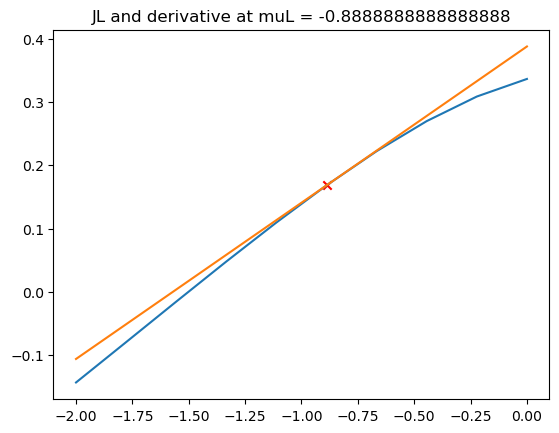

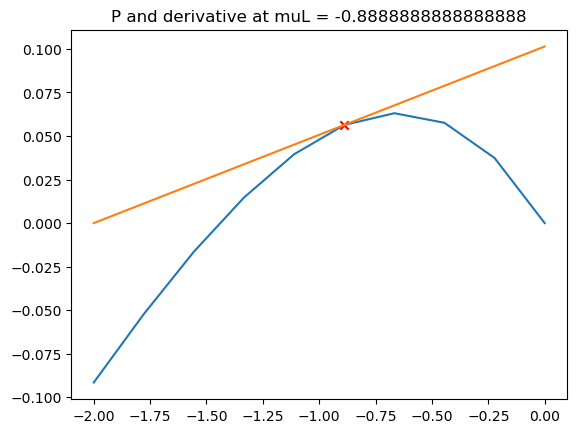

In [41]:
test_mus = np.linspace(-2,0,10)
test_heats = []
for mu in test_mus:
    test_heats.append(chunk_current_integral(transf, r_E, mu, TL, muR, TR, deltaE, foccup_L, type = "heat"))
test_heats = np.array(test_heats)
print(test_mus[mu_idx])
m = test_heats[mu_idx]-muL*Jprim
plt.plot(test_mus, test_heats)
plt.plot(test_mus, Jprim*test_mus + m)
plt.scatter(test_mus[mu_idx], test_heats[mu_idx], marker = 'x', c = 'r')
plt.title(f"JL and derivative at muL = {muL}")
#plt.xlim(-1.5, -0.75)
plt.show()

test_heatsL = []
for mu in test_mus:
    test_heatsL.append(chunk_current_integral(transf, r_E, mu, TL, muR, TR, deltaE, foccup_L, type = "heatR"))
test_heatsL = np.array(test_heatsL)

m_P = test_heats[mu_idx] + test_heatsL[mu_idx]-muL*Pprim
plt.plot(test_mus, test_heats + test_heatsL)
plt.plot(test_mus, Pprim*test_mus + m_P)
plt.scatter(test_mus[mu_idx], test_heats[mu_idx] + test_heatsL[mu_idx], marker = 'x', c = 'r')
plt.title(f"P and derivative at muL = {muL}")
#plt.xlim(-1.5, -0.75)
plt.show()


<>:103: SyntaxWarning: invalid escape sequence '\e'
<>:103: SyntaxWarning: invalid escape sequence '\e'
C:\Users\elsad\AppData\Local\Temp\ipykernel_15008\2971919620.py:103: SyntaxWarning: invalid escape sequence '\e'
  axs[1].hlines(c_eta, r_E[0], r_E[-1], 'r', label = f"$c_\eta$")


Temperature bias: 0.6666666666666665
Potential bias: -0.8888888888888888
Exchange energy: 0.8888888888888892

From chunk optimization:
Power output: 0.056322542503482856
Efficiency: 0.33487185693659965 
(Target: 0.05632254244888324)

From c_eta optimization:
Power output: 0.05632170262144122
Efficiency: 0.33589696623809917 
(Target: 0.05632254244888324)
[[0. 0. 0. ... 0. 0. 0.]]

From regular optimization
Power: 0.05632254244888327
Eff: 0.3358965893867148


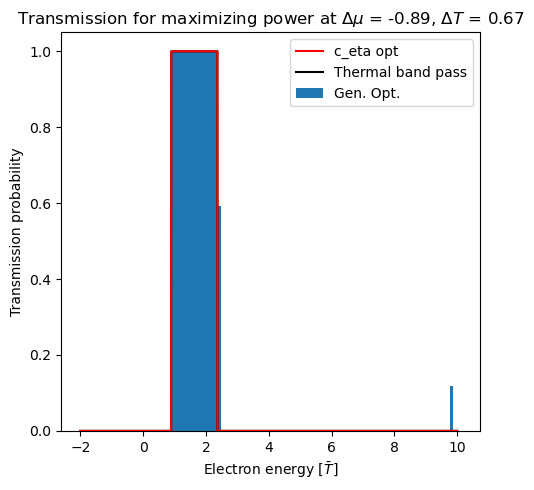

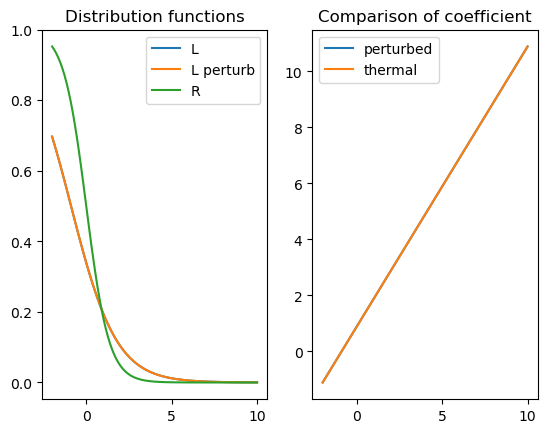

C:\Users\elsad\AppData\Local\Temp\ipykernel_15008\3716653343.py:5: RuntimeWarning: divide by zero encountered in divide
  coeff = -kb*TL*np.log(occupf_L(E, muL, TL)/(1-occupf_L(E, muL, TL)))
C:\Users\elsad\AppData\Local\Temp\ipykernel_15008\2971919620.py:79: RuntimeWarning: invalid value encountered in divide
  mom_etas_diff = lambda E: (E-log_coeff(E, muL, TL, foccup_L))/(-log_coeff(E, muL, TL, foccup_L))
C:\Users\elsad\AppData\Local\Temp\ipykernel_15008\137358323.py:3: RuntimeWarning: overflow encountered in exp
  f_dist = 1/(1+np.exp((E-mu)/(T*kb)))
C:\Users\elsad\AppData\Local\Temp\ipykernel_15008\3716653343.py:5: RuntimeWarning: divide by zero encountered in log
  coeff = -kb*TL*np.log(occupf_L(E, muL, TL)/(1-occupf_L(E, muL, TL)))
C:\Users\elsad\AppData\Local\Temp\ipykernel_15008\2971919620.py:90: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  mom_etas_zero = fsolve(mom_etas_diff, E_starts, factor=0.1)


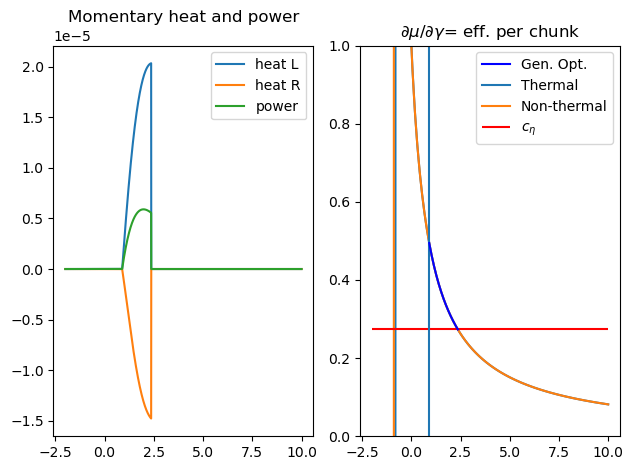

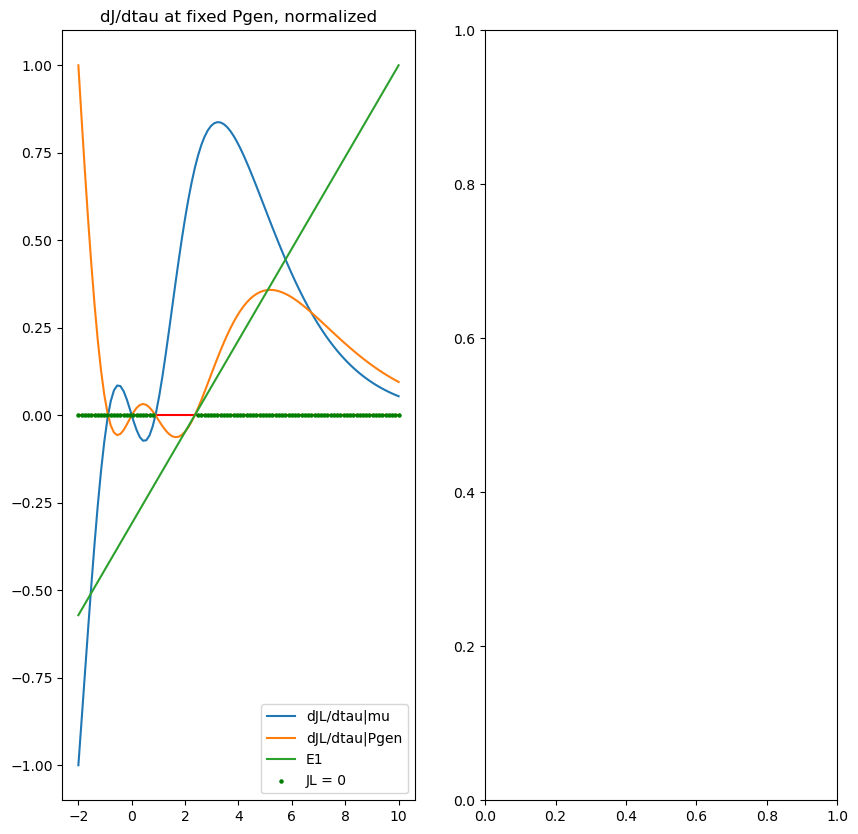

In [42]:

#TODO: Compare with exact solution
print(f"Temperature bias: {TL-TR}")
print(f"Potential bias: {muL-muR}")
print(f"Exchange energy: {E_max(muL, TL ,muR, TR)}")
print(f"\nFrom chunk optimization:")
print(f"Power output: {power_ch}")
print(f"Efficiency: {eff_ch} ")
print(f"(Target: {target})")

print(f"\nFrom c_eta optimization:")
print(f"Power output: {power_ch1}")
print(f"Efficiency: {eff_ch1} ")
print(f"(Target: {target})")

band = (np.heaviside(big_r_E-E0,1)*np.heaviside(E1-big_r_E,1))

print(transf1 - band)

fig = plt.figure(figsize=(5,5))

plt.bar(E_mids, transf, align='edge', width=deltaE, label = "Gen. Opt.", zorder = 1)
plt.plot(big_r_E, transf1, 'red', zorder =3, label = "c_eta opt")
#plt.plot(E_mids, transf, 'green')
#plt.vlines(exc_E,0,1, colors='red', label = "Exch. E")
#plt.vlines(muL*(1-Jprim_true/Pprim_true),0,1, colors='red', label = "E1")
#plt.vlines(muL*(1-Jprim/Pprim),0,1, colors='red', label = "E1")

#plt.title(fr"Transmission function maximizing power for given efficieny, $\eta =$ {target_eff:.2f} ")
plt.ylabel(f"Transmission probability")
plt.xlabel("Electron energy [meV]")
#plt.show()
# Visualize bandpasses

#print(E0)
#print(E1)
print(f"\nFrom regular optimization")
print(f"Power: {power[T_idx, mu_idx]}")
print(f"Eff: {eff[T_idx, mu_idx]}")
#fig = plt.figure()
plt.plot(big_r_E, band.T, 'black', alpha = 1, label = "Thermal band pass", zorder = 2)
plt.title(rf"Transmission for maximizing power at $\Delta \mu$ = {r_deltamu[mu_idx]:.2f}, $\Delta T$ = {r_deltaT[T_idx]:.2f}")
plt.ylabel("Transmission probability")
plt.xlabel(fr"Electron energy [$\bar T$]")
plt.legend()
plt.tight_layout()

plt.show()
#pertub = np.zeros_like(E_mids)
#pertub[np.argwhere(E_mids > 1)] = 0.2*np.sin(E_mids[np.argwhere(E_mids > 1)]*10)**2
fig, axs = plt.subplots(1,2)
axs[0].plot(r_E, fermi_dist(r_E, muL, TL), label = "L")
axs[0].plot(r_E, foccup_L(r_E,muL, TL), label = "L perturb")

axs[0].plot(r_E, fermi_dist(r_E, muR, TR), label = "R")
axs[0].set_title("Distribution functions")
axs[0].legend()

axs[1].plot(r_E, log_coeff(r_E, muL, TL, foccup_L), label = "perturbed")
axs[1].plot(r_E, r_E - muL, label = "thermal")
axs[1].set_title("Comparison of coefficient")
axs[1].legend()
plt.show()

nonzero_idxs = np.argwhere(transf > 1e-5)
mom_etas = np.ones_like(r_E)*np.nan
mom_etas[nonzero_idxs] = (heatR_inters[nonzero_idxs] + heat_inters[nonzero_idxs])/heat_inters[nonzero_idxs]
disc_r_E = np.ones_like(r_E)*np.nan
disc_r_E[nonzero_idxs] = r_E[nonzero_idxs]
#print(mom_etas[nonzero_idxs[-1]])

fig, axs = plt.subplots(1,2)
axs[0].plot(big_r_E, heat_inters1, label = "heat L")
axs[0].plot(big_r_E, heatR_inters1, label = "heat R")
axs[0].plot(big_r_E, heatR_inters1 + heat_inters1, label = "power")

axs[0].set_title("Momentary heat and power")
axs[0].legend()

mom_etas_diff = lambda E: (E-log_coeff(E, muL, TL, foccup_L))/(-log_coeff(E, muL, TL, foccup_L))
    #print(mom_etas_diff(np.array([1,2])))
occupdiff = lambda E: foccup_L(E,muL,TL)- fermi_dist(E,muR,TR)
#occup_zero = fsolve(occupdiff, r_E[0])

occup_zero = big_r_E[np.where(np.sign(occupdiff(big_r_E))[:-1] - np.sign(occupdiff(big_r_E))[1:] < 0)[0]]
    #print((occup_zero))
    #print(occupdiff(occup_zero + deltaE) -  occupdiff(occup_zero - deltaE))
    #if type(occup_zero) == float:
occup_zero = np.array([occup_zero])
E_starts = np.linspace(r_E[0], r_E[-1], 10)
mom_etas_zero = fsolve(mom_etas_diff, E_starts, factor=0.1)
mom_etas_zero = np.unique(mom_etas_zero.round(decimals=3))
    
axs[1].plot(disc_r_E, mom_etas, 'b', zorder = 3, label = "Gen. Opt.")
axs[1].plot(r_E, 1/(1-r_E/muL),zorder = 1, label = "Thermal")
axs[1].plot(big_r_E, (big_r_E-log_coeff(big_r_E, muL, TL, foccup_L))/(-log_coeff(big_r_E, muL, TL, foccup_L)), zorder = 2, label = "Non-thermal")
axs[1].set_ylim([0,1])
#axs[1].set_xlim([0,big_r_E[-1]])
#print(np.sum(1/(1-r_E/muL)))
#axs[1].scatter(mom_etas_zero, np.zeros_like(mom_etas_zero))
#print(np.unique(mom_etas_zero.round(decimals=3)))
#print(np.isclose(mom_etas_diff(mom_etas_zero), np.zeros_like(mom_etas_zero), atol = 1e-3))
#print(mom_etas_diff(mom_etas_zero))
axs[1].hlines(c_eta, r_E[0], r_E[-1], 'r', label = f"$c_\eta$")
axs[1].vlines(occup_zero, 0, 1)
axs[1].legend()
#axs[1].hlines(np.min(mom_etas[nonzero_idxs]), r_E[0], r_E[-1], 'r')
#0.40080972
#axs[1].plot(r_E, heatR_inters)
#axs[1].plot(r_E, heat_inters)
axs[1].set_title(rf"$\partial \mu/\partial \gamma $= eff. per chunk")
plt.tight_layout()
plt.show()

E1_stuff = -log_coeff(r_E, muL, TL, foccup_L)/(r_E-log_coeff(r_E, muL, TL, foccup_L)) - 1/c_eta
#E1_stuff = -(r_E-log_coeff(r_E, muL, TL, foccup_L))/log_coeff(r_E, muL, TL, foccup_L) - c_eta
#print(E1_stuff)

norm = True

zero_area = r_E[np.argwhere(np.abs(heat_inters)<1e-4)]
dJR_dtau = E1_stuff*dP_dtau
fig, axs = plt.subplots(1,2, figsize = (10,10))
if norm:
    axs[0].plot(r_E, dP_dtau/np.max(np.abs(dP_dtau)), label = "dJL/dtau|mu")
    #axs[0].plot(r_E, fermi_dist(r_E, muL, TL) + fpertub(r_E), label = "L perturb")

    #axs[0].plot(r_E, fermi_dist(r_E, muR, TR), label = "R")

    axs[0].plot(r_E, dJR_dtau/np.max(np.abs(dJR_dtau)), label = "dJL/dtau|Pgen")
    #print(r_E/(r_E+TL*kb*log_coeff(r_E, muL, TL, foccup_L)) - Jprim/Pprim)
    axs[0].plot(r_E, E1_stuff/np.max(np.abs(E1_stuff)), label = "E1")
    axs[0].scatter(zero_area, np.zeros_like(zero_area), c = 'green', s = 5, zorder = 2, label = "JL = 0")
    axs[0].hlines(0, r_E[0], r_E[-1], colors = 'red', zorder = 1)
    #axs[0].vlines(E1,-1,1, colors='red', label = "E1")

else:
    axs[0].plot(r_E, dP_dtau, label = "dJL/dtau|mu")
    axs[0].plot(r_E, dJR_dtau, label = "dJL/dtau|Pgen")
    axs[0].plot(r_E, E1_stuff, label = "E1")
axs[0].set_title("dJ/dtau at fixed Pgen, normalized")
axs[0].legend()

#axs[1].set_title("Comparison of coefficient")
#axs[1].legend()
plt.show()




In [43]:
# Calculate J_e = 0 curve
Je_zero_idx = []
for i, deltaT in enumerate(r_deltaT):
    flip_idx = np.where(power[i,:-1]*power[i,1:] < 0)[0] + 1
    if flip_idx.size > 0:
        flip_idx=flip_idx[0]
        Je_zero_idx.append(flip_idx if np.abs(power[i,flip_idx]) < power[i,flip_idx-1] else flip_idx-1)
        print(power[i, Je_zero_idx])
    else:
        Je_zero_idx.append(0)
Je_zero = r_electric[:, Je_zero_idx]
print(Je_zero)

[[-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 2.74227088e-05  2.74227088e-05  2.74227088e-05  2.74227088e-05
   2.74227088e-05  2.74227088e-05  2.74227088e-05  2.74227088e-05
   2.74227088e-05  2.74227088e-05]
 [ 4.91010882e-03  4.91010882e-03  4.91010882e-03  4.91010882e-03
   4.91010882e-03  4.91010882e-03  4.91010882e-03  4.91010882e-03
   4.91010882e-03  4.91010882e-03]
 [ 2.81612712e-02  2.81612712e-02  2.81612712e-02  2.81612712e-02
   2.81612712e-02  2.81612712e-02  2.81612712e-02  2.81612712e-02
   2.81612712e-02  2.81612712e-02]
 [ 5.00644822e-02  5.00644822e-02  5.00644822e-02  5.00644822e-02
   5.00644822e-02  5.00644822e-02  5.00644822e-02  5.00644822e-02
   5.00644822e-02  5.00644822e-02]
 [ 7.82257534e-02  7.82257534e-02  7.82257534e-02  7.82257534e-02
   7.82257534e-02  7.82257534e-02  7.82257534e-02  7.82257534e-02
   7.82257534e-02  7.82257534e-02

C:\Users\elsad\AppData\Local\Temp\ipykernel_15008\3072341112.py:2: RuntimeWarning: invalid value encountered in divide
  r_G = r_electric[0,1:]/r_deltamu[1:]
C:\Users\elsad\AppData\Local\Temp\ipykernel_15008\3072341112.py:5: RuntimeWarning: invalid value encountered in divide
  r_L = r_heat[0,1:]/r_deltamu[1:]
C:\Users\elsad\AppData\Local\Temp\ipykernel_15008\3072341112.py:16: RuntimeWarning: divide by zero encountered in divide
  r_S = -r_deltamu[Je_zero_idx]/r_deltaT
C:\Users\elsad\AppData\Local\Temp\ipykernel_15008\3072341112.py:21: RuntimeWarning: invalid value encountered in divide
  r_PI = r_heat[0,:]/r_electric[0,:]
C:\Users\elsad\AppData\Local\Temp\ipykernel_15008\3072341112.py:22: RuntimeWarning: invalid value encountered in scalar divide
  r_K = [r_heat[i,Je_zero_idx[i]]/r_deltaT[i] for i in range(len(r_deltaT))]


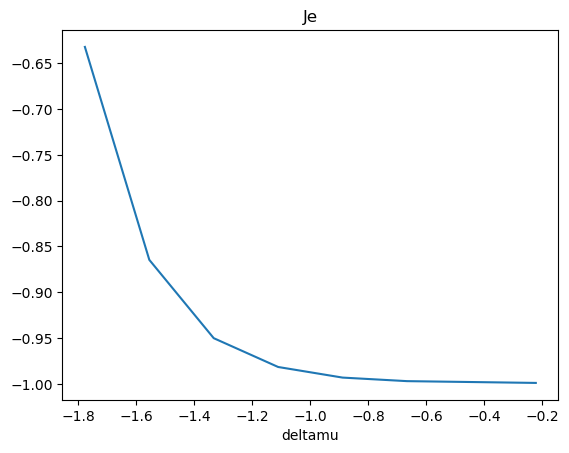

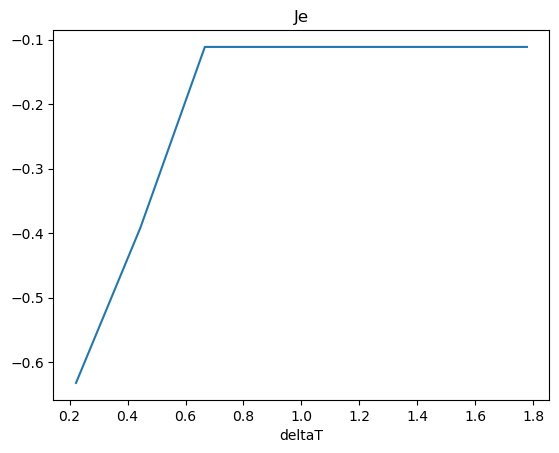

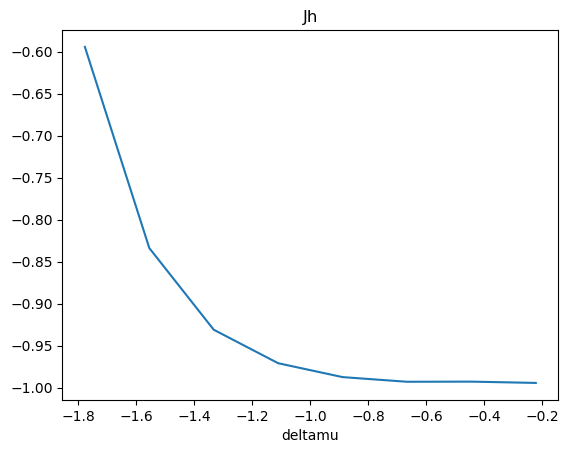

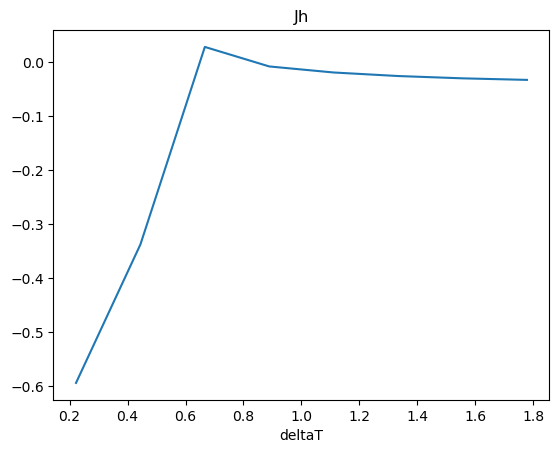

In [44]:
#Time to calculate the transport coefficients and check their asymptotic behaviors!
r_G = r_electric[0,1:]/r_deltamu[1:]
#Divide along the column

r_L = r_heat[0,1:]/r_deltamu[1:]

r_M = r_electric[1:, 0]/r_deltaT[1:]

r_Kplus = r_heat[1:, 0]/r_deltaT[1:]

diff_Je = ((r_G*r_deltamu[1:] + (r_M*r_deltaT[1:]).reshape(-1,1)) - r_electric[1:,1:])/r_electric[1:,1:]
diff_Jh = ((r_L*r_deltamu[1:] + (r_Kplus*r_deltaT[1:]).reshape(-1,1)) - r_heat[1:,1:])/r_heat[1:,1:]
check_Je = np.all(diff_Je < 1e-10)
check_Jh = np.all(diff_Jh < 1e-10)
#r_S = (r_M.reshape(-1,1)/r_G).T
r_S = -r_deltamu[Je_zero_idx]/r_deltaT
#r_K = r_heat[1:,:]/r_deltaT[1:].reshape(-1,1)

#r_S = -(r_deltamu[1:])/r_deltaT[1:].reshape(-1,1)

r_PI = r_heat[0,:]/r_electric[0,:]
r_K = [r_heat[i,Je_zero_idx[i]]/r_deltaT[i] for i in range(len(r_deltaT))]
#r_K = r_Kplus - r_G*r_S*r_PI[1:]

fig = plt.figure()
plt.plot(r_deltamu[1:], diff_Je[0,:])
plt.title("Je")
plt.xlabel("deltamu")
plt.show()
fig = plt.figure()
plt.plot(r_deltaT[1:], diff_Je[:,0])
plt.title("Je")
plt.xlabel("deltaT")
plt.show()
fig = plt.figure()
plt.title("Jh")
plt.plot(r_deltamu[1:], diff_Jh[0,:])
plt.xlabel("deltamu")
plt.show()
fig = plt.figure()
plt.title("Jh")
plt.xlabel("deltaT")
plt.plot(r_deltaT[1:], diff_Jh[:,0])
plt.show()


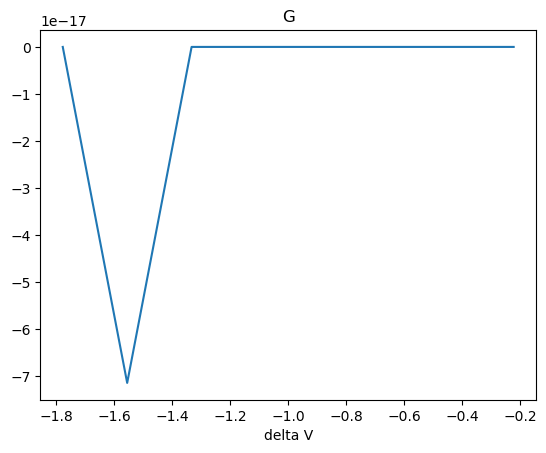

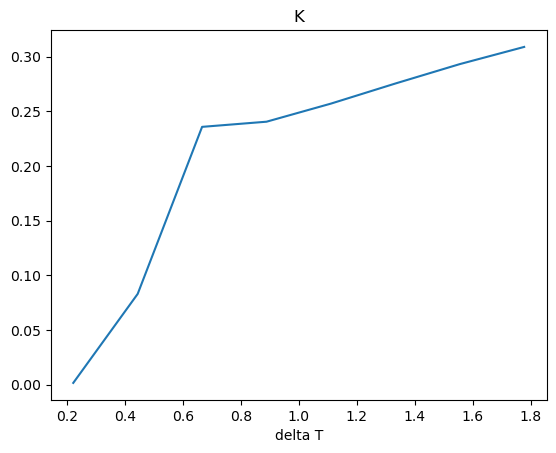

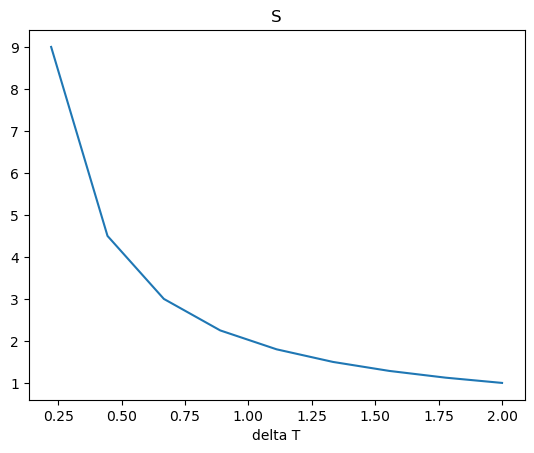

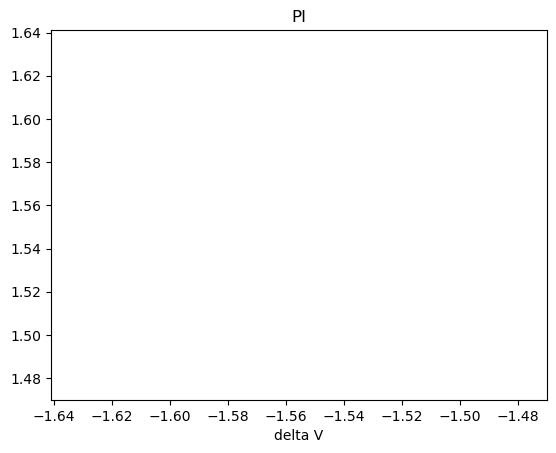

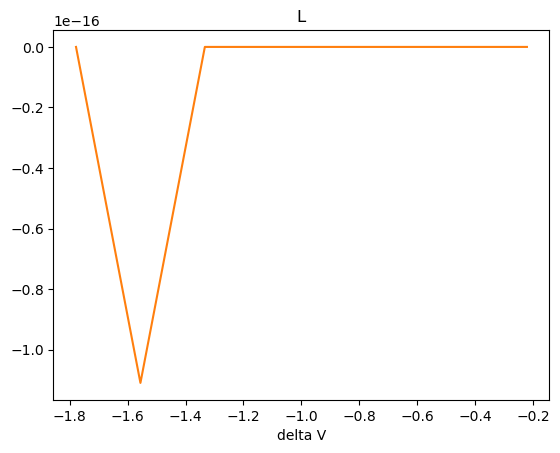

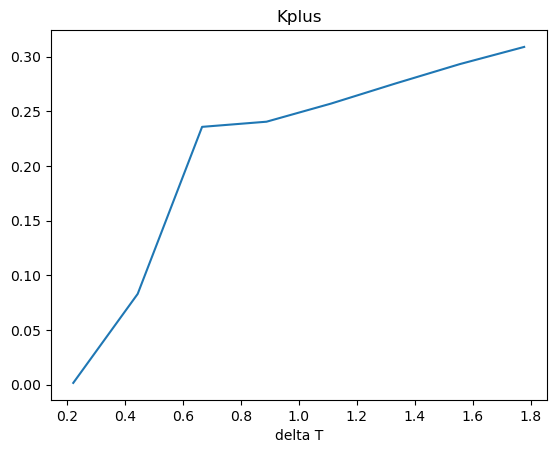

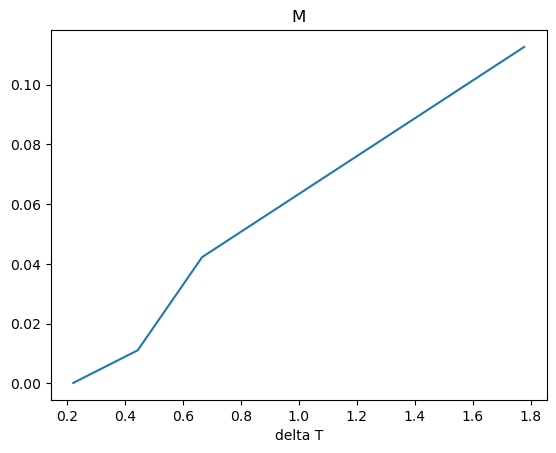

C:\Users\elsad\AppData\Local\Temp\ipykernel_15008\1395233957.py:46: RuntimeWarning: divide by zero encountered in divide
  plt.plot(r_deltaT[1:], (r_Kplus.reshape(-1,1)/r_G)[:,0])


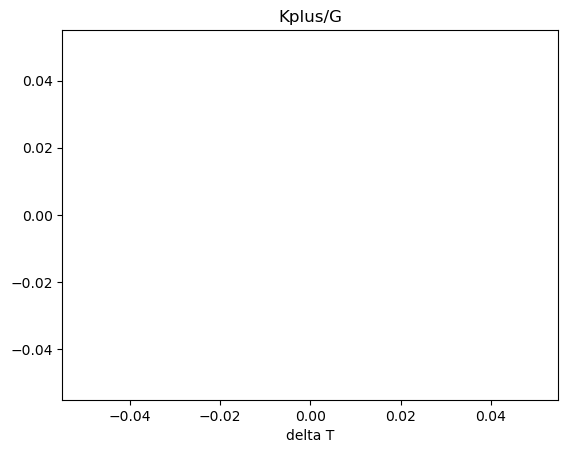

In [45]:
fig = plt.figure()
#plt.plot(r_electric[0,1:], r_G)
plt.plot(r_deltamu[1:], r_G)
plt.title("G")
plt.xlabel("delta V")
plt.show()
fig = plt.figure()
#plt.plot(r_electric[0,1:], r_G)
plt.plot(r_deltaT, r_K) #label = r_deltamu[0:10])
plt.title("K")
plt.xlabel("delta T")
plt.show()

fig = plt.figure()
plt.plot(r_deltaT, r_S)#, label = r_deltamu[1:10])
plt.title("S")
plt.xlabel("delta T")
plt.show()

fig = plt.figure()
plt.plot(r_deltamu, r_PI)
plt.title("PI")
plt.xlabel("delta V")
plt.show()

fig = plt.figure()
plt.plot(r_deltamu[1:], r_PI[1:]*r_G)
plt.plot(r_deltamu[1:], r_L)
plt.title("L")
plt.xlabel("delta V")
plt.show()

fig = plt.figure()
plt.plot(r_deltaT[1:], r_Kplus)
plt.title("Kplus")
plt.xlabel("delta T")
plt.show()

fig = plt.figure()
plt.plot(r_deltaT[1:], r_M)
plt.title("M")
plt.xlabel("delta T")
plt.show()

fig = plt.figure()
plt.plot(r_deltaT[1:], (r_Kplus.reshape(-1,1)/r_G)[:,0])
plt.title("Kplus/G")
plt.xlabel("delta T")
plt.show()